Consider that a pet food company is running a promotion. They will allocate to each bag of pet food one of three tokens: P, U, or Y. A customer wins a bag of pet food if they have enough tokens to spell the word PUPPY three times. They plan to allocate tokens to bags in the following probabilities:

| token | P(token) |
|-------|----------|
| P     | 0.5      |
| U     | 0.13     |
| Y     | 0.37     |

We want to use Monte Carlo simulations to derive the average number of bags a customer needs to buy to get a free bag under the current rules of the campaign.

Firstly, we consider that the above table represents a categorical distribution. Let us first write code to sample from this distribution using roulette wheel selection

In [2]:
# import statements for numerical and plotting libraries
%pylab inline 
import numpy

table = {
    'P': 0.5,
    'U': 0.13,
    'Y': 0.37
}

class RouletteWheel(object):
    
    def __init__(self, table):
        self.elems = []
        self.probs = []
        for elem, prob in table.items():
            self.elems.append(elem)
            self.probs.append(prob)
        self.probs = np.cumsum(self.probs)
        
    def sample(self):
        u = numpy.random.uniform(0, 1)
        for val, p in zip(self.elems, self.probs):
            if u <= p:
                return val

wheel = RouletteWheel(table) # wheel will allow us to sample multiple times
wheel.sample() # get a random sample

Populating the interactive namespace from numpy and matplotlib


/Users/inzamamrahaman/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


'Y'

Now let us consider the case of a single customer's sequence of purchasing bags and receiveing tokens. We assume that a customer will keep purchasing tokens until they get enough letters to spell PUPPY three times. To do this, they would need to acquire at least 9 P's , at least 3 U's, and at least 3 Y's. Thus, a single customer's acquisition of enough tokens to spell PUPPY 3 times is simply a case of randomly sampling from the distribution using *wheel.sample()* until we have enough tokens in suitable numbers.

In [3]:
def is_valid(record):
    enough_ps = record['P'] >= 9
    enough_us = record['U'] >= 9
    enough_ys = record['Y'] >= 9
    return enough_ps and enough_us and enough_ys

def simulate_customer():
    record = {
        'P': 0,
        'U': 0,
        'Y': 0
    }
    number_of_bags = 0 # customer starts off purchasing no bags
    while not is_valid(record): # they purchase until they have enough tokens
        token = wheel.sample() # bag contains token
        record[token] += 1 # add token to count
        number_of_bags += 1 # add to number of purchases made
    return number_of_bags

simulate_customer()

87

Now that we have the code to simulate for a single customer, we have all that we need for our monte carlo simulation. Remember, the core idea of monte carlo is that we simulate a random process many times (each called a **run**) and record those outputs. We can get the expected value for a process by simply taking the average of all runs. We may also be interested in the spread of the output as well as the entire distribution. We may even return all three (as shown below)

In [4]:
def monte_carlo(random_process, num_runs=10000): 
    """
    Uses monte carlo to get distribution of random variable under some process
    @param random_process: the random process for a single run encoded as a function
    @param num_runs: the number of runs 
    @return: the expected value of the random variable, the std. deviation of random variable, and distribution
    """
    results = []
    for run in range(num_runs):
        result = random_process() # simulate process once and record result
        results.append(result) # add result to observed distribution of results
    expected_value = np.mean(results) # get expected value
    std_deviation = np.std(results) # get std. deviation
    return expected_value, std_deviation, results

expected_number_of_bags, std_deviation_number_of_bags, numbers_of_bags = monte_carlo(simulate_customer)

In [5]:
print('The expected number of bags that a customer would need to purchase is ', expected_number_of_bags)

The expected number of bags that a customer would need to purchase is  69.343


Sometimes, it is interesting to see the distribution of the variable under study. We can learn a lot by simply plotting the results of all the runs asa histogram

(array([  1.04900000e+03,   2.95700000e+03,   2.98400000e+03,
          1.84900000e+03,   7.90000000e+02,   2.68000000e+02,
          8.00000000e+01,   2.00000000e+01,   2.00000000e+00,
          1.00000000e+00]),
 array([  27. ,   44.1,   61.2,   78.3,   95.4,  112.5,  129.6,  146.7,
         163.8,  180.9,  198. ]),
 <a list of 10 Patch objects>)

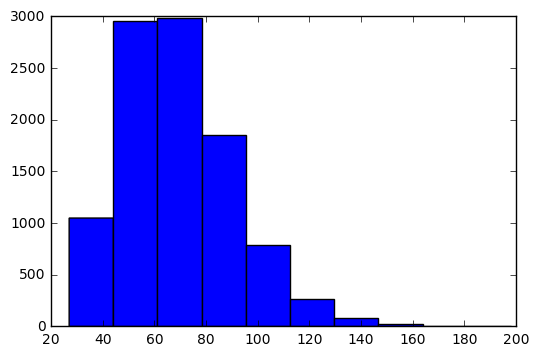

In [6]:
plt.hist(numbers_of_bags)

**Bonus**

Since each run is independent of each other, we can run them in parallel tospeed up the generation of the distribution, thereby allowing us to sample more values in a reasonable amount of time. In Python, we can leverage the *Pool* class of the *multiprocessing* module

In [11]:
from multiprocessing import Pool 

class IndexedSampler(object):
    def __init__(self, run):
        self.run = run 
    def run_process(self, x):
        return self.run()

def parallel_monte_carlo(random_process, num_runs=100000):
    pool = Pool() # process pool for parallelism
    runner = IndexedSampler(random_process) # we can't pickle functions, so need wrapper
    results = pool.map(runner.run_process, range(num_runs)) # run in parallel
    expected_value = np.mean(results)
    std_deviation = np.std(results)
    return expected_value, std_deviation, results


e2, s2, res2 = parallel_monte_carlo(simulate_customer)

In [12]:
print('Expected value ', e2)

Expected value  69.13452


(array([  9.42400000e+03,   2.66400000e+04,   3.10320000e+04,
          1.90960000e+04,   9.12400000e+03,   3.38000000e+03,
          9.92000000e+02,   2.24000000e+02,   6.80000000e+01,
          2.00000000e+01]),
 array([  27. ,   43.4,   59.8,   76.2,   92.6,  109. ,  125.4,  141.8,
         158.2,  174.6,  191. ]),
 <a list of 10 Patch objects>)

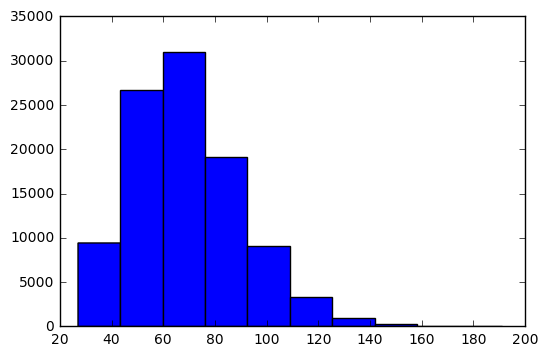

In [13]:
plt.hist(res2)